Getting only contexts from QuAC dataset and saving in txt file

In [3]:
import pandas as pd
import json

# Read the contents of the file
with open('dataset/train_quac.json', 'r', encoding='utf-8') as f:
    file_contents = f.read()

# Parse the JSON data
data = json.loads(file_contents)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data['data'])

# Extract the 'paragraphs' from each article
all_paragraphs = []
for article in df['paragraphs']:
    all_paragraphs.extend(article)

# Create a new DataFrame with all paragraphs
paragraphs_df = pd.DataFrame(all_paragraphs)

# Extract the 'context' from each paragraph
contexts = paragraphs_df['context']

# Save the contexts to a text file
with open('dataframe/qna/contexts.txt', 'w', encoding='utf-8') as f:
    for context in contexts:
        f.write(context + '\n')

print("Contexts have been saved to 'contexts.txt'")

Contexts have been saved to 'contexts.txt'


Getting id and context and saving in context.json format for passing the context in loop.

In [4]:
import json

# Read the contexts from the 'contexts.txt' file
with open('dataframe/qna/contexts.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()

# Create a list of dictionaries with 'id' and 'context' keys
data = []
for i, context in enumerate(contexts, start=1):
    data.append({'id': i, 'context': context.strip()})

# Write the data to a JSON file
with open('dataframe/qna/contexts.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

print("JSON file 'contexts.json' has been created.")


JSON file 'contexts.json' has been created.


spliting the context.txt into 10 files with 100 contexts each for further analysis. This is done to make sure only 1000 contexts with a batch of 100 contexts are used due to resource constraints. 

In [5]:
# Read the contexts from the 'contexts.txt' file
with open('dataframe/qna/contexts.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()

# Get the first 1000 contexts
contexts = contexts[:1000]

# Split the contexts into chunks of 100
context_chunks = [contexts[i:i+100] for i in range(0, len(contexts), 100)]

# Create 10 text files with 100 contexts per file
for i, chunk in enumerate(context_chunks, start=1):
    with open(f'dataframe/qna/contexts_files/contexts_{i}.txt', 'w', encoding='utf-8') as f:
        f.writelines(chunk)
    print(f"File 'contexts_{i}.txt' has been created with {len(chunk)} contexts.")


File 'contexts_1.txt' has been created with 100 contexts.
File 'contexts_2.txt' has been created with 100 contexts.
File 'contexts_3.txt' has been created with 100 contexts.
File 'contexts_4.txt' has been created with 100 contexts.
File 'contexts_5.txt' has been created with 100 contexts.
File 'contexts_6.txt' has been created with 100 contexts.
File 'contexts_7.txt' has been created with 100 contexts.
File 'contexts_8.txt' has been created with 100 contexts.
File 'contexts_9.txt' has been created with 100 contexts.
File 'contexts_10.txt' has been created with 100 contexts.


anthropic.claude-3-haiku-20240307-v1:0 \n dataframe/qna/contexts.json

### Function to generate first question from the context

System prompt: You are an AI assistant specialized in generating thought-provoking questions based on given contexts. Your task is to create a question that encourages critical thinking and deeper exploration of the topic presented in the context.

User message to be used as prompt:
Based on the following context, generate a thought-provoking question. Do not provide thought process in the output:\n\nContext: {context['context']}\n\nQuestion:


In [50]:
import os
import boto3
import json

def generate_question_from_context(context_id):
    # Load contexts from the JSON file
    with open('dataframe/qna/contexts.json', 'r') as file:
        contexts = json.load(file)

    # Find the context with the given ID
    context = next((item for item in contexts if item["id"] == context_id), None)
    if not context:
        return "Context not found."

    # Set up the Bedrock client
    bedrock_client = boto3.client('bedrock-runtime')

    # Define the system prompt
    system_prompts = [{"text": "You are an AI assistant specialized in generating thought-provoking questions based on given contexts. Your task is to create a question that encourages critical thinking and deeper exploration of the topic presented in the context."
                       }]

    # Prepare the user message with the context
    user_message = {
        "role": "user",
        "content": [
            {
                "text": f"Based on the following context, generate a thought-provoking question. Do not provide thought process in the output:\n\nContext: {context['context']}\n\nQuestion:"
            }
        ]
    }

    # Combine system prompt and user message
    messages = [user_message]

    # Call the Converse API
    response = bedrock_client.converse(
        modelId="anthropic.claude-3-haiku-20240307-v1:0",
        messages=messages,
        inferenceConfig={
            'maxTokens': 1000,
            'temperature': 0,
            'topP': 1.0
            },
        system=system_prompts
        )

    # Extract the generated question from the response
    generated_question = response['output']['message']['content'][0]['text']

    return context,generated_question

### Function to get knowledge base answer to be used as groundtruth answer from the followup questions. 

In [51]:
region  = "us-east-1"
kbId = "DXXXXXXXX3"
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_arn = f'arn:aws:bedrock:{region}::foundation-model/{model_id}'

In [52]:
bedrock_agent = boto3.client('bedrock-agent-runtime')
import pandas as pd
import boto3
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque

In [53]:
# Function to get answer from Bedrock Knowledge Base for a single turn

# Throttling mechanism
class ThrottleManager:
    def __init__(self, max_requests_per_second):
        self.max_requests_per_second = max_requests_per_second
        self.request_times = deque()

    def wait_if_needed(self):
        current_time = time.time()
        while self.request_times and current_time - self.request_times[0] > 1:
            self.request_times.popleft()
        
        if len(self.request_times) >= self.max_requests_per_second:
            sleep_time = 1 - (current_time - self.request_times[0])
            if sleep_time > 0:
                time.sleep(sleep_time)
        
        self.request_times.append(time.time())

# Initialize throttle manager (adjust the rate as needed)
throttle = ThrottleManager(max_requests_per_second=5)
def get_knowledge_base_turn_answer(question, story=None, session_id=None):
    throttle.wait_if_needed()
    
    try:
        input_text = f"Context: {story}\n\nQuestion: {question}" if story else question
        kwargs = {
            'input': {'text': input_text},
            'retrieveAndGenerateConfiguration': {
                'type': 'KNOWLEDGE_BASE',
                'knowledgeBaseConfiguration': {
                    'knowledgeBaseId': kbId,
                    'modelArn': model_arn
                }
            }
        }
        if session_id:
            kwargs['sessionId'] = session_id
        
        response = bedrock_agent.retrieve_and_generate(**kwargs)
        return response['output']['text'], response.get('sessionId')
    except Exception as e:
        print(f"Error querying Knowledge Base: {str(e)}")
        return f"Error: {str(e)}", None

### Function to generate followup question using context, previous question and previous answer 

Prompt:

You are an AI assistant tasked with generating follow-up questions based on a given context, previous question and previous answer.
Context: {context}
        
previous question: {previous_question}
previous answer: {previous_answer}
   
Generate a relevant follow-up question based on the context and the previous question and answer. The generated question should probe the candidate more based on the answer provided and the context must contain the answer to the followup question.
If the answer states that the search results don't provide any relevant information, then ask the followup question such that the context provided has the answer to the followup question.
Only provide followup question in the response. Ask only 1 followup question.

inferenceConfig={
                "temperature": 0.2,
                "topP": 0.9,
                "maxTokens": 500
            }
    

In [54]:
import boto3
import json
from botocore.exceptions import ClientError

def interactive_qa_session(context, previous_question,chat_history=None,last_question=False):
    if chat_history is None:
        chat_history = []

    # Get the answer to the first question
    previous_answer,sessionId = get_knowledge_base_turn_answer(previous_question, context)
    #print(f"previous answer is : {previous_answer}")

    # Add the Q&A pair to the chat history
    chat_history.append({"role": "user", "content": [{"text": previous_question}]})
    chat_history.append({"role": "assistant", "content": [{"text": previous_answer}]})

    # Generate a follow-up question using Amazon Bedrock Converse API
    try:
        bedrock_runtime = boto3.client('bedrock-runtime')
        
        system_message = f"""
        You are an AI assistant tasked with generating follow-up questions based on a given context, previous question and previous answer.
        Context: {context}
        
        previous question: {previous_question}
        previous answer: {previous_answer}
        
        
        Generate a relevant follow-up question based on the context and the previous question and answer. The generated question should probe the candidate more based on the answer provided and the context must contain the answer to the followup question.
        If the answer states that the search results don't provide any relevant information, then ask the followup question such that the context provided has the answer to the followup question.
        Only provide followup question in the response. Ask only 1 followup question.
        """

        messages = [
            {"role": "user", "content": [{"text": system_message}]},
        ]

        response = bedrock_runtime.converse(
            modelId='anthropic.claude-3-sonnet-20240229-v1:0',  # Use the appropriate model ID
            messages=messages,
            inferenceConfig={
                "temperature": 0.2,
                "topP": 0.9,
                "maxTokens": 500
            }
        )

        follow_up_question = response['output']['message']['content'][0]['text'].strip()

        return follow_up_question

    except ClientError as e:
        print(f"An error occurred while generating the follow-up question: {e}")
        return None

### Generating followup questions for different context IDs in batch of 20. 1 first question and 5 followup questions with corresponding answers to be created per context.

In [100]:
start_context_id = 661 # change this context ID number

In [101]:
import pandas as pd
from tqdm import tqdm  # for progress bar

# Create empty lists to store the data
data = {
    'turn_id': [],
    'context_id': [],
    'context': [],
    'question_type': [],
    'question': []
}

n_followup = 5  # number of follow-up questions per context
  # number of contexts to process
end_contexts_id = start_context_id + 40

# Iterate through all context IDs with progress bar
for context_id in tqdm(range(start_context_id, end_contexts_id), desc="Processing contexts"):
    try:
        # Generate the first question and get corresponding context from context ID
        context, first_question = generate_question_from_context(context_id)
        
        # Add first question data to the dictionary
        data['turn_id'].append(0)
        data['context_id'].append(context_id)
        data['context'].append(context['context'])
        data['question_type'].append('first_question')
        data['question'].append(first_question)
        
        previous_question = first_question
        
        # Generate follow-up questions for this context
        for i in range(n_followup):
            followup_question = interactive_qa_session(context["context"],previous_question)
            # Add follow-up question data to the dictionary
            data['turn_id'].append(i + 1)
            data['context_id'].append(context_id)
            data['context'].append(context['context'])
            data['question_type'].append('followup_question')
            data['question'].append(followup_question)
            
            previous_question = followup_question
            
    except Exception as e:
        print(f"Error processing context_id {context_id}: {str(e)}")
        continue

# Create DataFrame from the collected data
qa_df = pd.DataFrame(data)

# Add some basic statistics
total_questions = len(qa_df)
questions_per_context = qa_df.groupby('context_id').size()
unique_contexts = len(qa_df['context_id'].unique())

print("\nDataset Statistics:")
print(f"Total number of questions: {total_questions}")
print(f"Number of unique contexts: {unique_contexts}")

# Display sample of the DataFrame
print("\nSample of the Question-Answer DataFrame:")
print(qa_df.head())

# Additional useful information
print("\nContext ID distribution:")
print(qa_df['context_id'].value_counts().head())

# Basic data quality checks
print("\nData Quality Checks:")
print("Missing values:")
print(qa_df.isnull().sum())

# Optional: Create a summary DataFrame
summary_df = pd.DataFrame({
    'context_id': qa_df['context_id'].unique()
})
summary_df['num_questions'] = summary_df['context_id'].map(questions_per_context)
summary_df['has_first_question'] = summary_df['context_id'].map(
    lambda x: qa_df[(qa_df['context_id'] == x) & (qa_df['question_type'] == 'first_question')].shape[0] > 0
)
summary_df['num_followup_questions'] = summary_df['context_id'].map(
    lambda x: qa_df[(qa_df['context_id'] == x) & (qa_df['question_type'] == 'followup_question')].shape[0]
)

print("\nSummary Statistics by Context:")
print(summary_df.head())


Processing contexts: 100%|██████████| 40/40 [44:00<00:00, 66.00s/it]


Dataset Statistics:
Total number of questions: 240
Number of unique contexts: 40

Sample of the Question-Answer DataFrame:
   turn_id  context_id                                            context  \
0        0         661  Joy Division toured Continental Europe in Janu...   
1        1         661  Joy Division toured Continental Europe in Janu...   
2        2         661  Joy Division toured Continental Europe in Janu...   
3        3         661  Joy Division toured Continental Europe in Janu...   
4        4         661  Joy Division toured Continental Europe in Janu...   

       question_type                                           question  
0     first_question  How did Joy Division's touring schedule and re...  
1  followup_question  How did Ian Curtis's tragic death impact the r...  
2  followup_question  How did the members of New Order approach thei...  
3  followup_question  What were the circumstances surrounding Ian Cu...  
4  followup_question  What impact did Ian C

### Calculating :

1. Relatedness: How well does the question relate to the given context? (0 = completely unrelated, 1 = perfectly related)
2. Conciseness: How precise and to-the-point is the question? (0 = very verbose/unclear, 1 = perfectly concise)
3. Naturalness: How natural and well-formed is the question? (0 = artificial/awkward, 1 = perfectly natural)
4. Completeness: Does the context contain sufficient information to answer the question? (0 = no relevant information, 1 = complete information)

In [102]:
import re
def evaluate_question(context, question, region_name="us-east-1"):
    """
    Evaluate a single question-context pair using Claude 3 Haiku
    """
    try:
        # Initialize Bedrock client
        bedrock_runtime = boto3.client(
            service_name="bedrock-runtime",
            region_name=region_name
        )
        
        # Clean and validate input
        context = str(context).strip()
        question = str(question).strip()
        
        if not context or not question:
            print("Empty context or question")
            return None
        
        # Simplified prompt with strict instructions
        evaluation_prompt = f"""
        You are a question evaluator. Analyze the following context and question, then provide scores.
        Return ONLY a valid JSON object with no additional text or formatting.

        Context: {context}
        Question: {question}
    
        Definition:
        1. relatedness: How well does the question relate to the given context? (0 = completely unrelated, 1 = perfectly related)
        2. conciseness: How precise and to-the-point is the question? (0 = very verbose/unclear, 1 = perfectly concise)
        3. naturalness: How natural and well-formed is the question? (0 = artificial/awkward, 1 = perfectly natural)
        4. completeness: Does the context contain sufficient information to answer the question? (0 = no relevant information, 1 = complete information)

        Scores must be between 0 and 1 and needs to be float number.
        Use this exact format:
        {{
            "relatedness": {{
                "score": 0.8,
                "explanation": "brief explanation"
            }},
            "conciseness": {{
                "score": 0.8,
                "explanation": "brief explanation"
            }},
            "naturalness": {{
                "score": 0.8,
                "explanation": "brief explanation"
            }},
            "completeness": {{
                "score": 0.8,
                "explanation": "brief explanation"
            }}
        }}
        """
        
        # Create request payload
        request_payload = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 1000,
            "temperature": 0.1,
            "messages": [
                {
                    "role": "user",
                    "content": [{"type": "text", "text": evaluation_prompt}]
                }
            ]
        }
        
        # Invoke model
        response = bedrock_runtime.invoke_model(
            modelId="anthropic.claude-3-haiku-20240307-v1:0",
            body=json.dumps(request_payload)
        )
        
        # Parse response
        response_body = json.loads(response.get('body').read())
        response_text = response_body['content'][0]['text']
        
        # Extract JSON object
        json_match = re.search(r'\{[\s\S]*\}', response_text)
        if not json_match:
            return None
            
        # Parse JSON
        try:
            scores = json.loads(json_match.group(0))
            
            # Validate and clean scores
            metrics = ['relatedness', 'conciseness', 'naturalness', 'completeness']
            cleaned_scores = {}
            
            for metric in metrics:
                try:
                    score = scores[metric].get('score', 0.0)
                    explanation = scores[metric].get('explanation', '')
                    
                    # Ensure score is float between 0 and 1
                    try:
                        score = float(score)
                        score = max(0.0, min(1.0, score))
                    except (ValueError, TypeError):
                        score = 0.0
                        
                    cleaned_scores[metric] = {
                        'score': score,
                        'explanation': str(explanation)
                    }
                except KeyError:
                    cleaned_scores[metric] = {
                        'score': 0.0,
                        'explanation': ''
                    }
            
            return cleaned_scores
            
        except json.JSONDecodeError:
            return None
            
    except Exception as e:
        print(f"Error in evaluate_question: {str(e)}")
        return None

def process_dataframe(df, batch_size=5):
    """
    Process DataFrame and add evaluation scores
    """
    # Initialize columns
    metrics = ['relatedness', 'conciseness', 'naturalness', 'completeness']
    for metric in metrics:
        df[f'{metric}_score'] = 0.0
        df[f'{metric}_explanation'] = ''
    
    total_rows = len(df)
    
    # Process in batches
    for start_idx in range(0, total_rows, batch_size):
        end_idx = min(start_idx + batch_size, total_rows)
        print(f"\nProcessing rows {start_idx + 1} to {end_idx} of {total_rows}")
        
        for idx in range(start_idx, end_idx):
            try:
                # Get context and question
                context = str(df.iloc[idx]['context']).strip()
                question = str(df.iloc[idx]['question']).strip()
                
                if not context or not question:
                    print(f"Skipping row {idx + 1}: Empty context or question")
                    continue
                
                print(f"\nProcessing row {idx + 1}:")
                print(f"Question: {question[:100]}...")
                
                # Get evaluation scores
                scores = evaluate_question(context, question)
                
                if scores:
                    # Update DataFrame with scores
                    for metric in metrics:
                        if metric in scores:
                            df.at[idx, f'{metric}_score'] = scores[metric]['score']
                            df.at[idx, f'{metric}_explanation'] = scores[metric]['explanation']
                    print("Evaluation completed successfully")
                else:
                    print(f"Failed to get valid scores for row {idx + 1}")
                
            except Exception as e:
                print(f"Error processing row {idx + 1}: {str(e)}")
                continue
    
    return df

# Example usage
if __name__ == "__main__":
    try:
        # Load CSV file
        #input_file = "qa_session_data_20241119_114859.csv"
        df = qa_df
        
        if 'context' not in df.columns or 'question' not in df.columns:
            print("Error: CSV must contain 'context' and 'question' columns")
        else:
            # Process the DataFrame
            results_df = process_dataframe(df)
            
            # Save results
            output_file = "dataframe/evaluation/evaluation_results_" + str(start_context_id) + "-" + str(end_contexts_id) + ".csv"
            results_df.to_csv(output_file, index=False)
            print(f"\nResults saved to {output_file}")
            
            # Display summary statistics
            score_cols = [col for col in results_df.columns if col.endswith('_score')]
            print("\nScore Summary:")
            print(results_df[score_cols].describe())
            
    except Exception as e:
        print(f"Error: {str(e)}")



Processing rows 1 to 5 of 240

Processing row 1:
Question: How did Joy Division's touring schedule and recording process contribute to Ian Curtis's declining m...
Evaluation completed successfully

Processing row 2:
Question: How did Ian Curtis's tragic death impact the remaining members of Joy Division, and what was the sig...
Evaluation completed successfully

Processing row 3:
Question: How did the members of New Order approach their new musical direction and sound after transitioning ...
Evaluation completed successfully

Processing row 4:
Question: What were the circumstances surrounding Ian Curtis's death in May 1980?...
Evaluation completed successfully

Processing row 5:
Question: What impact did Ian Curtis's death have on the remaining members of Joy Division and their future mu...
Evaluation completed successfully

Processing rows 6 to 10 of 240

Processing row 6:
Question: What specific challenges did the remaining members of Joy Division face in transitioning to their ne..

### Removing all rows with empty columns

In [103]:
def remove_empty_rows(df):
    """
    Remove all rows that contain any empty values (NaN, None, or empty string) in any column.
    
    Args:
        df (pandas.DataFrame): Input DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with empty rows removed
    """
    try:
        # Store original shape
        original_shape = df.shape
        
        # Remove rows with NaN or None values
        df_cleaned = df.dropna()
        
        # Remove rows with empty strings or whitespace
        df_cleaned = df_cleaned[~df_cleaned.astype(str).apply(lambda x: x.str.strip().eq(''), axis=1).any(axis=1)]
        
        # Reset index
        df_cleaned = df_cleaned.reset_index(drop=True)
        
        # Print summary
        rows_removed = original_shape[0] - df_cleaned.shape[0]
        print(f"\nRows removal summary:")
        print(f"Original rows: {original_shape[0]}")
        print(f"Rows removed: {rows_removed}")
        print(f"Remaining rows: {df_cleaned.shape[0]}")
        
        return df_cleaned
        
    except Exception as e:
        print(f"Error cleaning DataFrame: {str(e)}")
        return df


In [104]:
try:
    # Remove empty rows
    df_cleaned = remove_empty_rows(results_df)

    # Save cleaned DataFrame
    output_file = "dataframe/evaluation/cleaned/cleaned_data_"+ str(start_context_id) + "-" + str(end_contexts_id) + ".csv"
    df_cleaned.to_csv(output_file, index=False)
    print(f"\nCleaned data saved to: {output_file}")

except Exception as e:
    print(f"Error: {str(e)}")


Rows removal summary:
Original rows: 240
Rows removed: 24
Remaining rows: 216

Cleaned data saved to: dataframe/evaluation/cleaned/cleaned_data_661-701.csv


In [105]:
!pwd

/home/ec2-user/SageMaker/MS


In [109]:
import pandas as pd
import glob
import os

def merge_csv_files(folder_path, output_file='merged.csv'):
    # Get all CSV files in the folder
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    # Create a list to store all dataframes
    df_list = []
    
    # Read each CSV file and append to the list
    for file in all_files:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {str(e)}")
    
    # Concatenate all dataframes
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Save to new CSV file
        combined_df.to_csv(output_file, index=False)
        print(f"Successfully merged {len(all_files)} files into {output_file}")
    else:
        print("No CSV files found to merge")

# Usage
folder_path = "dataframe/evaluation/cleaned/"
merge_csv_files(folder_path)


Successfully merged 17 files into merged.csv


### Calculating average score of all metrics per context ID

Get the relatedness_score, conciseness, naturalness and completeness score and create a table in report.

In [110]:
def calculate_overall_metrics_statistics(df):
    """
    Calculate overall statistics for the four main metrics.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the metrics
        
    Returns:
        pandas.DataFrame: DataFrame with overall statistics for each metric
    """
    try:
        # Define the metrics we want to analyze
        metrics = ['relatedness_score', 'conciseness_score', 'naturalness_score', 'completeness_score']
        
        # Calculate statistics for each metric
        stats = {}
        for metric in metrics:
            stats[metric] = {
                'mean': df[metric].mean(),
                'median': df[metric].median(),
                'std': df[metric].std(),
                'min': df[metric].min(),
                'max': df[metric].max(),
                'count': df[metric].count()
            }
        
        # Convert to DataFrame and transpose for better readability
        stats_df = pd.DataFrame(stats).round(3)
        stats_df = stats_df.transpose()
        
        # Calculate overall average across all metrics
        overall_average = df[metrics].mean().mean()
        
        # Print summary
        print("\nOverall Metrics Statistics:")
        print("-" * 50)
        print(stats_df)
        print("\nOverall average across all metrics:", round(overall_average, 3))
        
        # Create distribution summary
        print("\nScore Distribution Summary:")
        print("-" * 50)
        for metric in metrics:
            bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
            distribution = pd.cut(df[metric], bins=bins).value_counts().sort_index()
            total_count = len(df[metric])
            
            print(f"\n{metric}:")
            print("Score Range    Count    Percentage")
            print("-" * 40)
            for interval, count in distribution.items():
                percentage = (count / total_count) * 100
                print(f"{interval}: {count:5d}    {percentage:6.2f}%")
        
        return stats_df
        
    except Exception as e:
        print(f"Error calculating statistics: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Load your data
        df = pd.read_csv("dataframe/combined/merged.csv")
        
        # Calculate statistics
        stats_df = calculate_overall_metrics_statistics(df)
            
    except Exception as e:
        print(f"Error: {str(e)}")



Overall Metrics Statistics:
--------------------------------------------------
                     mean  median    std  min  max   count
relatedness_score   0.888     0.9  0.078  0.0  1.0  3634.0
conciseness_score   0.868     0.9  0.062  0.0  1.0  3634.0
naturalness_score   0.894     0.9  0.047  0.0  1.0  3634.0
completeness_score  0.861     0.9  0.099  0.0  1.0  3634.0

Overall average across all metrics: 0.878

Score Distribution Summary:
--------------------------------------------------

relatedness_score:
Score Range    Count    Percentage
----------------------------------------
(0.0, 0.2]:     4      0.11%
(0.2, 0.4]:     3      0.08%
(0.4, 0.6]:    13      0.36%
(0.6, 0.8]:   227      6.25%
(0.8, 1.0]:  3369     92.71%

conciseness_score:
Score Range    Count    Percentage
----------------------------------------
(0.0, 0.2]:     0      0.00%
(0.2, 0.4]:     0      0.00%
(0.4, 0.6]:     0      0.00%
(0.6, 0.8]:  1141     31.40%
(0.8, 1.0]:  2486     68.41%

naturalness_score:


### Calculating average metrics based on turn numbers

In [112]:
def calculate_turn_metrics_average(df):
    """
    Calculate average metrics for each turn_id separately.
    
    Args:
        df (pandas.DataFrame): DataFrame containing metrics and turn_id
        
    Returns:
        pandas.DataFrame: DataFrame with averaged metrics for each turn_id
    """
    try:
        # Define the metrics we want to analyze
        metrics = ['relatedness_score', 'conciseness_score', 'naturalness_score', 'completeness_score']
        
        # Verify required columns exist
        required_columns = ['turn_id'] + metrics
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Group by turn_id and calculate means
        turn_averages = df.groupby('turn_id')[metrics].agg({
            'relatedness_score': 'mean',
            'conciseness_score': 'mean',
            'naturalness_score': 'mean',
            'completeness_score': 'mean'
        }).round(3)
        
        # Add count of samples for each turn
        turn_averages['sample_count'] = df.groupby('turn_id').size()
        
        # Calculate overall average for each turn
        turn_averages['overall_average'] = turn_averages[metrics].mean(axis=1).round(3)
        
        # Sort by turn_id
        turn_averages = turn_averages.sort_index()
        
        # Print summary
        print("\nMetrics Average by Turn ID:")
        print("-" * 50)
        print(turn_averages)
        
        print("\nDetailed Statistics by Turn:")
        print("-" * 50)
        for turn in turn_averages.index:
            print(f"\nTurn {turn}:")
            print(f"Sample count: {turn_averages.loc[turn, 'sample_count']}")
            print(f"Overall average: {turn_averages.loc[turn, 'overall_average']}")
            print("\nIndividual metrics:")
            for metric in metrics:
                print(f"{metric}: {turn_averages.loc[turn, metric]}")
        
        return turn_averages
        
    except Exception as e:
        print(f"Error calculating turn metrics: {str(e)}")
        return None

# Example usage
if __name__ == "__main__":
    try:
        # Load your data
        df = pd.read_csv("dataframe/combined/merged.csv")
        
        # Calculate turn-based metrics
        turn_averages = calculate_turn_metrics_average(df)
        
        #if turn_averages is not None:
            # Save results
            #turn_averages.to_csv("turn_metrics_averages.csv")
            
            # Generate visualizations
            #visualize_turn_metrics(turn_averages)
                
    except Exception as e:
        print(f"Error: {str(e)}")



Metrics Average by Turn ID:
--------------------------------------------------
         relatedness_score  conciseness_score  naturalness_score  \
turn_id                                                            
0                    0.900              0.862              0.900   
1                    0.896              0.868              0.898   
2                    0.889              0.870              0.895   
3                    0.880              0.868              0.893   
4                    0.877              0.867              0.887   
5                    0.886              0.874              0.894   

         completeness_score  sample_count  overall_average  
turn_id                                                     
0                     0.893           608            0.889  
1                     0.880           597            0.886  
2                     0.860           597            0.878  
3                     0.843           614            0.871  
4        


Metrics Average by Turn ID:
--------------------------------------------------
         relatedness_score  conciseness_score  naturalness_score  \
turn_id                                                            
0                    0.900              0.862              0.900   
1                    0.896              0.868              0.898   
2                    0.889              0.870              0.895   
3                    0.880              0.868              0.893   
4                    0.877              0.867              0.887   
5                    0.886              0.874              0.894   

         completeness_score  sample_count  overall_average  
turn_id                                                     
0                     0.893           608            0.889  
1                     0.880           597            0.886  
2                     0.860           597            0.878  
3                     0.843           614            0.871  
4        

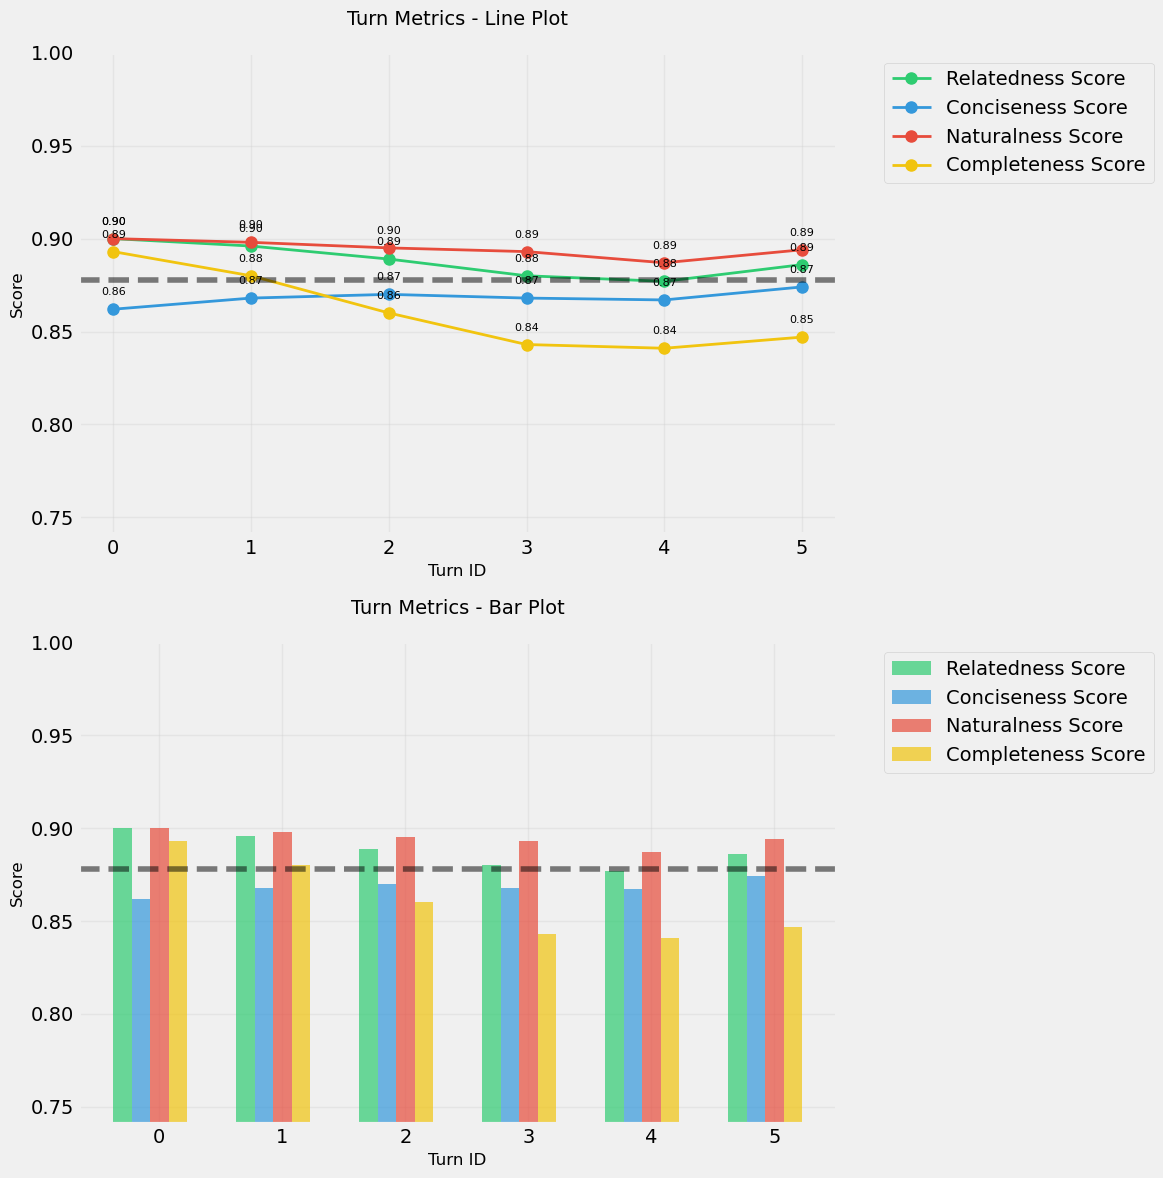

In [113]:
import matplotlib.pyplot as plt

def visualize_turn_metrics(turn_averages):
    """
    Create visualizations for turn metrics.
    
    Args:
        turn_averages (pandas.DataFrame): DataFrame containing averaged metrics for each turn_id
    """
    # Set style to a valid matplotlib style
    plt.style.use('fivethirtyeight')  # or use 'ggplot' or 'classic'
    
    # Create figure and axis with larger size
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Get metrics columns (excluding sample_count and overall_average)
    metrics = [col for col in turn_averages.columns 
              if col not in ['sample_count', 'overall_average']]
    
    # Color palette for consistency across plots
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
    
    # Line Plot
    for metric, color in zip(metrics, colors):
        ax1.plot(turn_averages.index, turn_averages[metric], 
                marker='o', label=metric.replace('_', ' ').title(),
                color=color, linewidth=2, markersize=8)
    
    ax1.set_title('Turn Metrics - Line Plot', fontsize=14, pad=20)
    ax1.set_xlabel('Turn ID', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust y-axis to better show differences
    y_min = turn_averages[metrics].min().min() - 0.1
    y_max = turn_averages[metrics].max().max() + 0.1
    ax1.set_ylim(y_min, y_max)
    
    # Bar Plot
    bar_width = 0.15
    positions = range(len(turn_averages.index))
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        offset = bar_width * (i - len(metrics)/2)
        ax2.bar([p + offset for p in positions], 
                turn_averages[metric], 
                bar_width, 
                label=metric.replace('_', ' ').title(),
                color=color,
                alpha=0.7)
    
    ax2.set_title('Turn Metrics - Bar Plot', fontsize=14, pad=20)
    ax2.set_xlabel('Turn ID', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_xticks(positions)
    ax2.set_xticklabels(turn_averages.index)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust y-axis to better show differences
    ax2.set_ylim(y_min, y_max)
    
    # Add overall average line to both plots
    overall_mean = turn_averages['overall_average'].mean()
    ax1.axhline(y=overall_mean, 
                color='black', linestyle='--', 
                alpha=0.5, 
                label='Mean Overall Average')
    ax2.axhline(y=overall_mean, 
                color='black', linestyle='--', 
                alpha=0.5, 
                label='Mean Overall Average')
    
    # Add value labels on the line plot
    for metric in metrics:
        for x, y in zip(turn_averages.index, turn_averages[metric]):
            ax1.annotate(f'{y:.2f}', 
                        (x, y), 
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center',
                        fontsize=8)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show plot
    plt.show()

# Update your main code to include the visualization
if __name__ == "__main__":
    try:
        # Load your data
        df = pd.read_csv("dataframe/combined/merged.csv")
        
        # Calculate turn-based metrics
        turn_averages = calculate_turn_metrics_average(df)
        
        if turn_averages is not None:
            # Generate visualizations
            visualize_turn_metrics(turn_averages)
                
    except Exception as e:
        print(f"Error: {str(e)}")
